# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I will use the tools I learned about in the lesson to identify lane lines on the road.  I developed a pipeline on a series of individual images, and later applyed the result to a video stream. As a reviewer, you can using _Kernel->Restart and Run All_ from the Jupyter menu to run everything and check the result on local disk.


**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

## Some tests with K-mean clustering
To see if the setup contains sklean packages. That should give you an image of random points consisting of 4 clusters if you go with the docker starter kit setup.

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


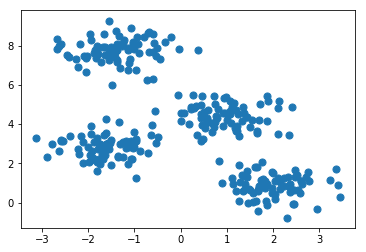

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


## Some tests with reading images

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


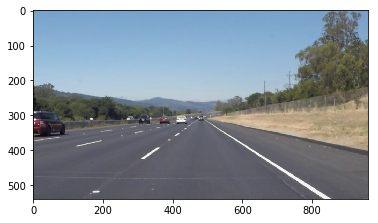

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions provided in the template.

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draw lines with specified color and thickness. The lines arg should be an array-like
    object containing four float numbers specifying the end points of the line.
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def generate_line_images(lines, height, width, draw_line_callback, draw_extrapolated_lines=None):
    """
    Draw lines aftger hough transform, and extrapolate lines if a callback object is provided.
    """
    line_img = np.zeros((height, width, 3), dtype=np.uint8)
    extrapolated_line_img = np.zeros((height, width, 3), dtype=np.uint8)
    if lines is not None:
        draw_line_callback(line_img, lines)
        if draw_extrapolated_lines is not None:
            try:
                draw_extrapolated_lines.draw(extrapolated_line_img, lines)
            except LaneNotFoundException as e:
                print(e.msg)
    return line_img, extrapolated_line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Image test cases

Test the pipeline to work on the images in the directory `test_images`

In [5]:
import os
test_images = os.listdir("test_images/")
test_images

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Define the pipeline as follows.

In [6]:
# My pipeline here
# Saved output to the "test_images_output" directory.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from collections import deque

class LaneNotFoundException(Exception):
    def __init__(self, msg):
        self.msg = msg;
        
class Line:
    def __init__(self, line_coeff, line_length):
        self.line_coeff = line_coeff
        self.line_length = line_length

class DrawLinesExtrapolate:
    
    def __init__(self, color=(0, 255, 0), thickness=4, interpolate_frames=0):
        
        self.color = color
        self.thickness = thickness
        self.left_line_accum = deque([], interpolate_frames)
        self.right_line_accum = deque([], interpolate_frames)
        
    def setImageDimension(self, width, height):
        self.width = width
        self.height = height
    
    # Another strategy is to weigh the coefficients based on the length of the line
    def weighCoeffs(self, coeffs):
        count = len(coeffs)
        
        weighs = np.zeros(count)

        # This gives out an weigh array that sums up to 1
        for i in range(count):
            weighs[i] = (count - i) ** 2

        weighs /= sum(weighs)
        #print(weighs, sum(weighs))
        
        line_averaged = np.zeros(2)
        for i in range(count):
            line_averaged += coeffs[i] * weighs[i]
        
        return line_averaged
    
    # One of the strategy is just give arithmetic mean of the coefficients
    def averageCoeffs(self, coeffs):
        count = len(coeffs)
        if count > 0:        
            coeffs_averaged = np.zeros(2)
            for i in range(count):
                coeffs_averaged += coeffs[i]

            coeffs_averaged /= count
            return coeffs_averaged
        else:
            return coeffs
        
    def draw(self, img, lines):    
        noise_count = 0
        lines_coeff = []
        
        # Pass 1, sort the lines base on the length. After sorting, the longest comes first in the list
        line_objs = []
        for line in lines:
            x1,y1,x2,y2 = line[0]
            d = np.linalg.norm((x1-x2, y1-y2))
            line_objs.append(Line(line, d))
            
        line_objs.sort(key=lambda line: line.line_length, reverse=True)
        
        
        # Pass 2, cluster the lines into two categories
        for line in line_objs:
            for x1,y1,x2,y2 in line.line_coeff:
                extrapolated_line = np.polyfit((x1, x2), (y1, y2), 1)
                # divide the lines into two categories, left and right
                lines_coeff.append(extrapolated_line)

        kmeans = KMeans(n_clusters=2)
        kmeans.fit(lines_coeff)
        lines_cat = kmeans.predict(lines_coeff)
        
        # Pass 3, put the line coefficients into each categories' list while removing some noises, 
        leftright_lines_coeff = [[], []]
        leftright_lines_slope_averaged = [np.array([0.0, 0.0]), np.array([0.0, 0.0])]
        for i in range(len(lines_coeff)):
            cat = lines_cat[i]
            coeff = lines_coeff[i]
            
            a = coeff[0]
            if a > 0.3 and a < 3.33:
                leftright_lines_coeff[cat].append(coeff)
                leftright_lines_slope_averaged[cat] += coeff
            elif a < -0.3 and a > -3.33:
                leftright_lines_coeff[cat].append(coeff)
                leftright_lines_slope_averaged[cat] += coeff
            else:
                noise_count += 1
                
        
        leftright_lines_slope_averaged[0] /= len(leftright_lines_coeff[0])
        leftright_lines_slope_averaged[1] /= len(leftright_lines_coeff[1])
              
        # Decide which category is left and which is right
        left_cat, right_cat = 0, 1
        # Swap if necessary
        if leftright_lines_slope_averaged[0][0] > 0:
            right_cat, left_cat = 0, 1
            
        left_count = len(leftright_lines_coeff[left_cat])
        right_count = len(leftright_lines_coeff[right_cat])
        #print("Left: " + str(left_count)  + " Right: " + str(right_count) + " Noise: " + str(noise_count))
        
        # Pass 4, accumulate the weighed sum based on the line length.
        # Generate weighs and normalise them
        
        # One way to do it just simply average them all
#         left_line_averaged = self.averageCoeffs(leftright_lines_coeff[left_cat])
#         right_line_averaged = self.averageCoeffs(leftright_lines_coeff[right_cat])
        
        # Here we choose to weigh each coefficients based on the line length sorted earlier
        left_line_averaged = self.weighCoeffs(leftright_lines_coeff[left_cat])
        right_line_averaged = self.weighCoeffs(leftright_lines_coeff[right_cat])
        
        # Smooth out the lines by averaging the coefficients and interpolate from the past estimations
        # Then draw them out
        left_x_middle = 0.48
        right_x_middle = 1 - left_x_middle
        smoothed_left_line_averaged = None
        smoothed_right_line_averaged = None
        
        if left_count > 0:
            # accumulate
            self.left_line_accum.append(left_line_averaged)
            if len(self.left_line_accum) > 0:    
                smoothed_left_line_averaged = sum(self.left_line_accum) / len(self.left_line_accum)
            else:
                smoothed_left_line_averaged = left_line_averaged
        elif len(self.left_line_accum) > 0:
            # Guess from previous estimations
            smoothed_left_line_averaged = sum(self.left_line_accum) / len(self.left_line_accum)
            
        if smoothed_left_line_averaged is not None:
            poly = np.poly1d(smoothed_left_line_averaged)
            xlimit = (0, self.width * left_x_middle)
            cv2.line(img, (int(xlimit[0]), int(poly(xlimit[0]))), (int(xlimit[1]), int(poly(xlimit[1]))), self.color, self.thickness)

            

        if right_count > 0:
            # accumulate
            self.right_line_accum.append(right_line_averaged)
            if len(self.right_line_accum) > 0:
                smoothed_right_line_averaged = sum(self.right_line_accum) / len(self.right_line_accum)
            else:
                smoothed_right_line_averaged = right_line_averaged
        elif len(self.right_line_accum) > 0:
            # Guess from previous estimations
            smoothed_right_line_averaged = sum(self.right_line_accum) / len(self.right_line_accum)
        
        if smoothed_right_line_averaged is not None:
            poly = np.poly1d(smoothed_right_line_averaged)
            xlimit = (self.width * right_x_middle, self.width)
            cv2.line(img, (int(xlimit[0]), int(poly(xlimit[0]))), (int(xlimit[1]), int(poly(xlimit[1]))), self.color, self.thickness)
  
        # Raise lane not found exceptions to notify the caller
        if left_count == 0:
            raise LaneNotFoundException("Left lane not found")
        if right_count == 0:
            raise LaneNotFoundException("Right lane not found")



def read_image(image_filename):
    return mpimg.imread(image_filename)

def mark_lanes_from_image(input_image, extrapolate_obj, showimg_obj=None, original_filename=None):
    if showimg_obj is not None:
       showimg_obj.show(input_image, False)
    
    # Step 1, convert the image to grayscale
    my_img = grayscale(input_image)
    if showimg_obj is not None:
       showimg_obj.show(my_img, True)

    # Step 2, Gaussian blur, kernel size==5
    my_img = gaussian_blur(my_img, 5)
    if showimg_obj is not None:
       showimg_obj.show(my_img, True)

    # Step 3, Canny transform, low==130, high==200
    my_img = canny(my_img, 110, 200)
    if showimg_obj is not None:
       showimg_obj.show(my_img, True)

    # Step 4, masking using a trapezoid
    my_img_height = my_img.shape[0]
    my_img_width = my_img.shape[1]
    a = 0.45
    b = 0.6
    masking_vertices = np.array([[(0, my_img_height),(my_img_width*a, my_img_height * b), (my_img_width*(1.0-a), my_img_height * b), (my_img_width, my_img_height)]], dtype=np.int32)
    my_img = region_of_interest(my_img, masking_vertices)
    if showimg_obj is not None:
        showimg_obj.show(my_img, True)
    # Step 5, Hough transform
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi * 1.0 /180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(my_img, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Step 6 and 7, draw lines and extrapolate lines
    my_img, blendline_img  = generate_line_images(lines, my_img.shape[0], my_img.shape[1], draw_lines, extrapolate_obj)
    if showimg_obj is not None:
        showimg_obj.show(my_img, False)
        showimg_obj.show(blendline_img, False, save_filename=original_filename)
        
    return my_img, blendline_img


## Test on Images
The pipeline will be run over all the `test_images` and produce results into the `test_images_output` diredctory.

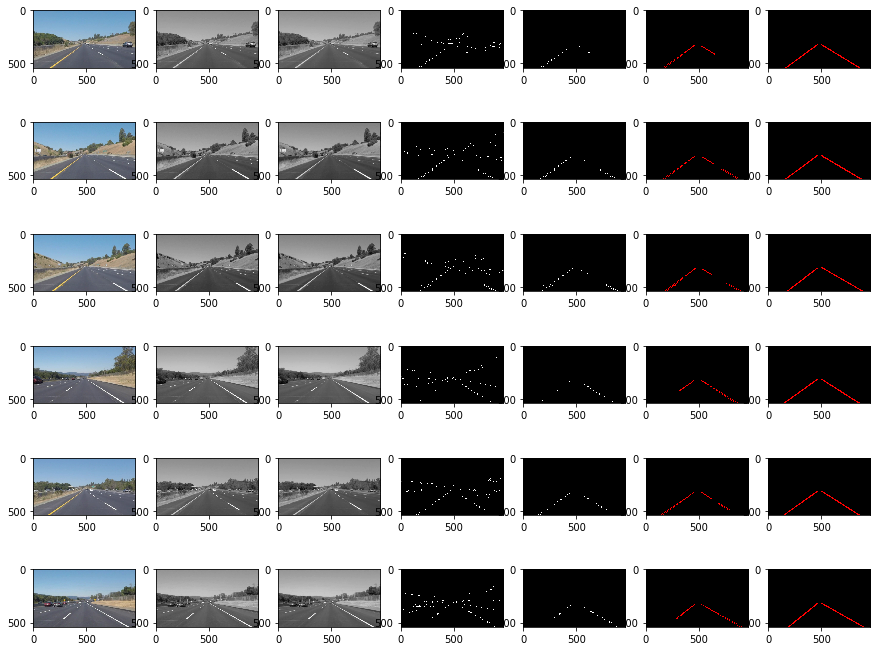

In [7]:
# Test on images
rows = len(test_images)
cols = 7
fig=plt.figure(figsize=(15, 12))

class ShowFigImage:
    def __init__(self, rows, cols, fig, save_directory):
        self.rows = rows
        self.cols = cols
        self.fig = fig
        self.index = 1
        self.save_directory = save_directory
        
    def show(self, image, is_grey, save_filename=None):
        fig.add_subplot(self.rows, self.cols, self.index)
        if is_grey:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
            
        if save_filename is not None:
            cv2.imwrite(os.path.join(self.save_directory, save_filename), image)
            
        self.index += 1
        

showfig = ShowFigImage(rows, cols, fig, save_directory='test_images_output')
extrapolate = DrawLinesExtrapolate(color=(255, 0, 0), thickness=10)

# Plot the image from left to right: original image, grayscale, after gaussaion blur, canny edge detection, masked edge detection, line detection, line estimation
for test_img_filename in test_images:
    filename = os.path.join('test_images', test_img_filename)
    origin_img = read_image(filename)
    img_height = origin_img.shape[0]
    img_width = origin_img.shape[1]
    extrapolate.setImageDimension(img_width, img_height)
    lines_img, extrapolated_lines_img = mark_lanes_from_image(origin_img, extrapolate, showimg_obj = showfig)
    final_img = weighted_img(extrapolated_lines_img, origin_img, α=0.8, β=0.5, γ=0.0)
    mpimg.imsave(os.path.join('test_images_output', test_img_filename), final_img, format='jpg')
    
plt.savefig(os.path.join('test_images_output', "pipeline_demo.png"))

## Test on Videos

Now apply the same pipeline on videos provided `solidWhiteRight.mp4` and `solidYellowLeft.mp4`. Find the output video in `test_videos_output` directory.

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
# Annotate the video using the actual detected line images
def process_image(origin_img):
    # NOTE: The output should be a color image (3 channel) for processing video below
    lines_img, extrapolated_lines_img = mark_lanes_from_image(origin_img, None)
    final_img = weighted_img(lines_img, origin_img, α=0.8, β=0.5, γ=0.0)

    return final_img

## Basic 'vanilla' line annotation
The `solidWhiteRight.mp4` video will be annotated with actual identified lines.

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:01<00:00, 126.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.87 s, sys: 217 ms, total: 2.09 s
Wall time: 2.04 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improved line annotation

Here's the improved, extrapolated line detection applies on the video `solidYellowLeft.mp4`.

In [12]:
# Redefine image processing, it will blend in the extrapolated lines instead of actual found lines

extrapolate = DrawLinesExtrapolate(color=(255, 0, 0), thickness=10)

def process_image(origin_img):
    extrapolate.setImageDimension(origin_img.shape[1], origin_img.shape[0])
    lines_img, extrapolated_lines_img = mark_lanes_from_image(origin_img, extrapolate)
    final_img = weighted_img(extrapolated_lines_img, origin_img, α=0.8, β=0.5, γ=0.0)

    return final_img

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 68.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.7 s, sys: 643 ms, total: 12.4 s
Wall time: 10.1 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Here's the optional `challenge.mp4` result. The line detection generally works with a few drifting when hitting the extreme lighting condition changes. There're a few warnings about the lanes detection not working as the lighting condition is tricky. They can be safely ignored.

In [15]:
# Redefine image processing, it will blend in the extrapolated lines instead of actual found lines.
# Furthermore it will interpolate from previous estimation to maintain a stable lane finding. Assume the camera's
# framerate is 24 fps, the interpolated time is 1.5 seconds.
extrapolate = DrawLinesExtrapolate(color=(255, 0, 0), thickness=10, interpolate_frames=36)

def process_image(origin_img):

    extrapolate.setImageDimension(origin_img.shape[1], origin_img.shape[0])
    lines_img, extrapolated_lines_img = mark_lanes_from_image(origin_img, extrapolate)
    final_img = weighted_img(extrapolated_lines_img, origin_img, α=0.8, β=0.5, γ=0.0)

    return final_img

In [16]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 49%|████▊     | 122/251 [00:02<00:03, 42.50it/s]

Left lane not found
Left lane not found
Left lane not found


 53%|█████▎    | 132/251 [00:03<00:02, 41.22it/s]

Left lane not found
Left lane not found


100%|██████████| 251/251 [00:05<00:00, 43.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.59 s, sys: 462 ms, total: 7.05 s
Wall time: 6.29 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Writeup

Finally here's my [writeup](https://github.com/fengye/CarND-LaneLines-P1/blob/master/writeup.md). Thank you for your time!